<a href="https://colab.research.google.com/github/almendruki/Cosas-TDA/blob/main/tarea_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install numpy scipy matplotlib networkx ripser scikit-tda gudhi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.1/842.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=b7d7d20d487657b2eda8c7a4dc663f38e2813ff8210bf41212964257664cfb60
  Stored in directory: /root/.cache/pip/wheels/2a/fd/fe/f4b8fd82894e1d9e04040ef41dc5ae6eb7a8e9b0ef5a9402fe
Successfully built hopcroftkarp


In [8]:
#tarea 2 jaja
#implementar 'Boundary_mod2' y combprueba con ejemplos
#la frontera de la frontera
from itertools import combinations
from typing import Tuple, List, Set

Simplex = Tuple

def faces(simplex: Simplex) -> List[Simplex]:
    """Devuelve las caras de dimensión (d-1) de un simplex de dimensión d.
    El resultado está en forma de tuplas ordenadas (orden lexicográfico por defecto).
    """
    if len(simplex) <= 1:
        return []
    return [tuple(s) for s in combinations(simplex, len(simplex)-1)]

def boundary_mod2(simplex: Simplex) -> List[Simplex]:
    """Frontera en coeficientes mod 2: la frontera es la suma (simétrica) de sus caras.
    Para coeficientes en Z2 podemos devolver la lista de caras (sin signos).
    """
    return faces(simplex)
# Comprobación: frontera de la frontera debería ser vacía (∂^2 = 0) en coeficientes F2.
from collections import Counter

def boundary_of_chain_mod2(chain: List[Simplex]) -> List[Simplex]:
    """Dado un chain (lista de simplices con multiplicidad 1 en F2), devuelve su frontera (mod 2).
    La operación suma las listas y cancela las caras con multiplicidad par.
    """
    c = Counter()
    for simplex in chain:
        for face in boundary_mod2(simplex):
            c[face] += 1
    # mantener solo aquellas con cuenta impar
    return [face for face,count in c.items() if count % 2 == 1] # (a + b) % 2

#ejemplos
simplex_2 = ('A','B','C')
boundary_2 = boundary_mod2(simplex_2)
print(boundary_2)
simplex_3 = ('A','B','C','D')
boundary_3 = boundary_mod2(simplex_3)


print(boundary_of_chain_mod2(boundary_2))
print(boundary_of_chain_mod2(boundary_3))

[('A', 'B'), ('A', 'C'), ('B', 'C')]
[]
[]


In [5]:
# construye matriz frontera para un complejo dado y calcula beta_0 y beta_1

#generamos un complejo

from collections import defaultdict

class SimplicialComplex:
    def __init__(self, simplices: List[Simplex]):
        # normalizar: convertir cada simplex a tupla ordenada y asegurar que incluye todas las caras
        self.simplices = set(tuple(sorted(s)) for s in simplices)
        self._close_under_faces()

    def _close_under_faces(self):
        add = set()
        for s in list(self.simplices):
            for k in range(1, len(s)):
                for f in combinations(s, k):
                    add.add(tuple(sorted(f)))
        self.simplices |= add

    def vertices(self) -> Set:
        v = set()
        for s in self.simplices:
            for x in s:
                v.add(x)
        return v

    def simplices_of_dim(self, d:int) -> List[Simplex]:
        return [s for s in self.simplices if len(s)==d+1]

    def max_dimension(self) -> int:
        return max(len(s)-1 for s in self.simplices) if self.simplices else -1

    def __repr__(self):
        return f"SimplicialComplex({len(self.simplices)} simplices, dim={self.max_dimension()})"


#generamos matriz de frontera
import numpy as np

def boundary_matrix_F2(complex: SimplicialComplex, d: int) -> np.ndarray:
    """Construye la matriz de frontera ∂_d: C_d -> C_{d-1} sobre F2.
    Filas: (d-1)-simplices, Columnas: d-simplices.
    Entrada (i,j) = 1 si la i-ésima (d-1)-cara está en la frontera de la j-ésima d-simplex.
    """
    d_simplices = sorted(complex.simplices_of_dim(d))
    dm1_simplices = sorted(complex.simplices_of_dim(d-1))
    idx_dm1 = {s:i for i,s in enumerate(dm1_simplices)}
    mat = np.zeros((len(dm1_simplices), len(d_simplices)), dtype=np.uint8)
    for j,s in enumerate(d_simplices):
        for f in faces(s):
            i = idx_dm1.get(tuple(sorted(f)))
            if i is not None:
                mat[i,j] = 1  # en F2 no necesitamos signo
    return mat, d_simplices, dm1_simplices

# Reducir modulo 2 por filas (Gauss sobre GF(2))

def rank_F2(mat: np.ndarray) -> int:
    """Computa el rango de una matriz binaria sobre GF(2) usando eliminación por filas.
    Mat debe tener dtype uint8 o bool.
    """
    A = mat.copy().astype(np.uint8)
    m,n = A.shape
    rank = 0
    row = 0
    for col in range(n):
        # buscar pivot en row..m-1
        pivot = None
        for r in range(row, m):
            if A[r,col] == 1:
                pivot = r
                break
        if pivot is None:
            continue
        # swap
        if pivot != row:
            A[[pivot,row]] = A[[row,pivot]]
        # eliminar abajo
        for r in range(m):
            if r != row and A[r,col] == 1:
                A[r,:] ^= A[row,:]
        row += 1
        rank += 1
        if row == m:
            break
    return rank

# Función para calcular Betti d dados rango(s)

def betti_numbers(complex: SimplicialComplex):
    maxd = complex.max_dimension()
    bettis = {}
    for d in range(maxd+1):
        C_d = len(complex.simplices_of_dim(d))
        mat_d,_,_ = boundary_matrix_F2(complex, d)
        rank_d = rank_F2(mat_d) if mat_d.size else 0
        mat_dp1,_,_ = boundary_matrix_F2(complex, d+1)
        rank_dp1 = rank_F2(mat_dp1) if mat_dp1.size else 0
        # β_d = dim Ker ∂_d - dim Im ∂_{d+1}
        dim_ker = C_d - rank_d
        dim_im = rank_dp1
        bettis[d] = dim_ker - dim_im
    return bettis

In [15]:
simp_2 = SimplicialComplex([simplex_2])
simp_3 = SimplicialComplex([simplex_3])
print(simp_2)
print(simp_3)

M2, d_s_2, dm1_s_2 = boundary_matrix_F2(simp_2, 2)
M3, d_s_3, dm1_s_3 = boundary_matrix_F2(simp_3, 3)
print(M2)
print(M3)

print('Rangos 2:', rank_F2(M2))
print('Betti 2:', betti_numbers(simp_2))
print('Rangos 3:', rank_F2(M3))
print('Betti 3:', betti_numbers(simp_3))



SimplicialComplex(7 simplices, dim=2)
SimplicialComplex(15 simplices, dim=3)
[[1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 [1]]
Rangos 2: 1
Betti 2: {0: 1, 1: 0, 2: 0}
Rangos 3: 1
Betti 3: {0: 1, 1: 0, 2: 0, 3: 0}


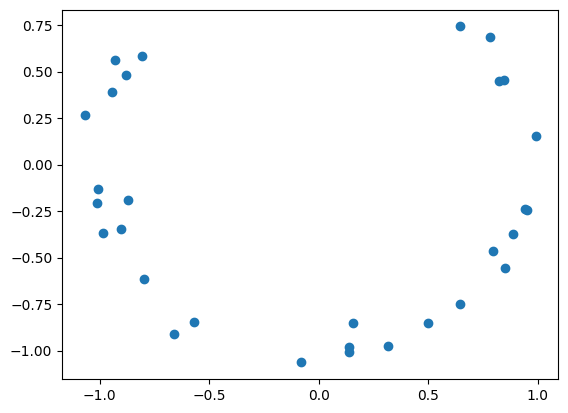

Diagramas (H0, H1):
[[0.         0.01106782]
 [0.         0.02563487]
 [0.         0.0276677 ]
 [0.         0.07352518]
 [0.         0.08641572]]
[[1.46041226 1.66472065]
 [0.16372636 0.17940496]]


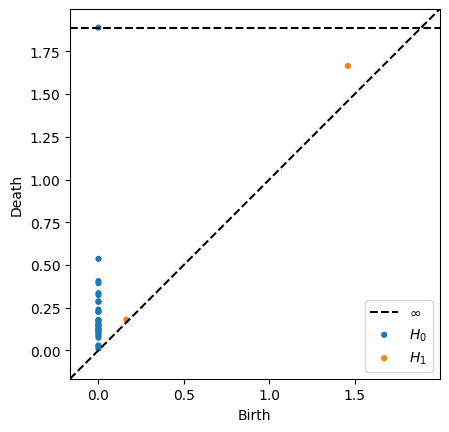

In [22]:
#Genera 30 puntos en forma de anillo con ruido; calcula diagrama de persistencia (VR) y discute los resultados.
import numpy as np
from ripser import ripser
from persim import plot_diagrams
import networkx as nx
import matplotlib.pyplot as plt

# generar puntos en un círculo con ruido
def sample_noisy_circle(n=100, radius=1.0, noise=0.08, random_state=0):
    rng = np.random.RandomState(random_state)
    thetas = rng.uniform(0,2*np.pi,n)
    xs = radius * np.column_stack([np.cos(thetas), np.sin(thetas)])
    xs += rng.normal(scale=noise, size=xs.shape)
    return xs

X = sample_noisy_circle(n=30, noise=0.06)
plt.scatter(X[:,0], X[:,1])
plt.show()

# Calcular diagramas de persistencia
res = ripser(X, maxdim=1)
dgms = res['dgms']

print('Diagramas (H0, H1):')
print(dgms[0][:5])
print(dgms[1][:10])


# Plot
plot_diagrams(dgms, show=True)

Descargando Fashion-MNIST (puede tomar unos segundos)...
Forma de la muestra: (100, 784) -> 100 imágenes de 784 píxeles
Diagramas (H0, H1) calculados para el dataset real.


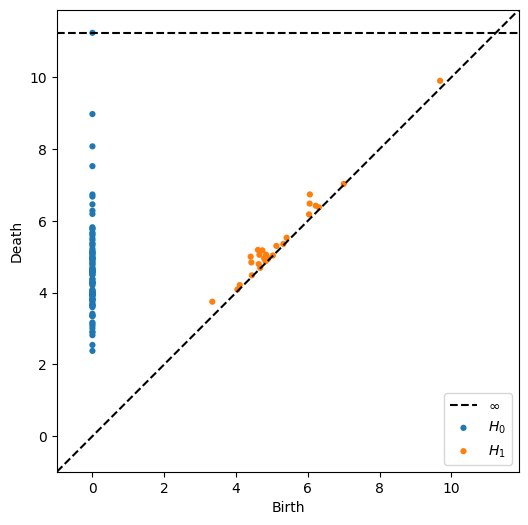

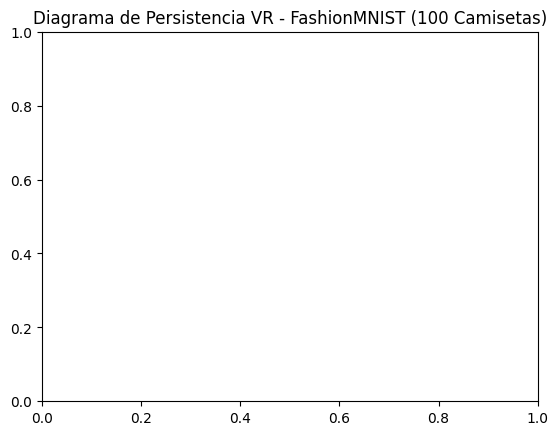

In [23]:
# =========================================================================
# EXTRA: Dataset Real (FashionMNIST) y Vietoris-Rips con Matriz de Distancia
# =========================================================================
from sklearn.datasets import fetch_openml
from scipy.spatial.distance import pdist, squareform

# 1. Definimos la función personalizada solicitada
def calcular_matriz_distancias(X):
    """Calcula la matriz de distancias euclidianas"""
    distancias = pdist(X, metric='euclidean')
    matriz_dist = squareform(distancias)
    return matriz_dist

print("Descargando Fashion-MNIST (puede tomar unos segundos)...")
# fetch_openml trae el dataset como un DataFrame de Pandas
fmnist = fetch_openml('Fashion-MNIST', version=1, parser='auto')
X_full = fmnist.data.values
y_full = fmnist.target.values

# 2. Seleccionamos una muestra
# Tomaremos la clase '0' que corresponde a "Camisetas"
mask_camisetas = (y_full == '0')
# Nos quedamos con solo 100 imágenes para que Ripser corra rápido en el notebook
X_sample = X_full[mask_camisetas][:100]

# Normalizamos los valores de los píxeles (de 0-255 a 0-1)
X_sample = X_sample / 255.0

print(f"Forma de la muestra: {X_sample.shape} -> 100 imágenes de 784 píxeles")

# 3. Aplicamos matriz de distancias y Vietoris-Rips
D = calcular_matriz_distancias(X_sample)

# IMPORTANTE: distance_matrix=True le dice a Ripser que no calcule distancias, sino que use D
res_extra = ripser(D, distance_matrix=True, maxdim=1)
dgms_extra = res_extra['dgms']

print('Diagramas (H0, H1) calculados para el dataset real.')

# 4. Plot (siguiendo tu estilo)
plt.figure(figsize=(8, 6))
plot_diagrams(dgms_extra, show=True)
plt.title("Diagrama de Persistencia VR - FashionMNIST (100 Camisetas)")
plt.show()